# Collateral connectivity between ommatidia
WORK IN PROGRESS
- Quantifies the number of connections in the lamina connectome between neurons associated with different ommatidia (collateral connections)
- Displays the interommatidial flow of information facilitated by this collateral connectivity

This analysis focuses on L4 and L2, which were the only lamina subtypes exhibiting clear collateral arbors. These collaterals are also found to be exclusively postsynaptic, i.e. they ***receive*** inputs from external ommatidia. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vis.hex_lattice import hexplot
from vis.colour_palettes import subtype_cm
from vis.fig_tools import linear_cmap

In [3]:
tp = '200507'
data_path = f"~/Data/{tp}_lamina/{tp}"
cx = pd.read_pickle(data_path + "_cxdf.pickle")
links = pd.read_pickle(data_path + "_linkdf.pickle")

In [4]:
collateral_links = []
home_links = []
om_list = []

for i, l in links.iterrows():
    if (l.post_om != 'UNKNOWN'):
        om_list.append(l.pre_om)
        
    if (l.pre_om != l.post_om) and (l.post_om != 'UNKNOWN'):
        collateral_links.append(l)
    elif (l.pre_om == l.post_om) and (l.post_om != 'UNKNOWN'):
        home_links.append(l)
    else:
        continue
    
om_list = list(sorted(set(om_list)))
collaterals = pd.DataFrame(collateral_links)
homes = pd.DataFrame(home_links)

display(f"Total contacts: {len(links)}")
display(f"Total identified contacts: {len(homes) + len(collaterals)}")
display(f"% UNKNOWN: {int(sum(links.post_om == 'UNKNOWN'))/int(len(links)) * 100.0}")
display(f"Number of interom contacts: {len(collaterals)}")
display(f"Number of home contacts: {len(homes)}")
display(f"Interom % of total: {float(len(collaterals))/float(len(homes) + len(collaterals))}")

'Total contacts: 20631'

'Total identified contacts: 19326'

'% UNKNOWN: 6.325432601425041'

'Number of interom contacts: 842'

'Number of home contacts: 18484'

'Interom % of total: 0.043568250025871884'

pre_type
LMC_1       1
LMC_2     240
LMC_N       4
R1R4       78
R2R5      175
R3R6      104
centri     46
Name: link_id, dtype: int64

(array([1., 0., 1., 0., 1., 0., 5., 0., 7., 4.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

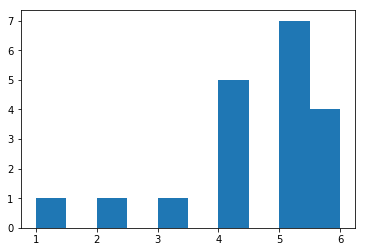

In [5]:
l4_co = collaterals.loc[collaterals['post_type'] == 'LMC_4']
fig, ax = plt.subplots(1)

display(l4_co.groupby('pre_type')['link_id'].nunique())
ax.hist(l4_co.groupby('post_om')['pre_type'].nunique())

In [6]:
data = []

for post_om, links in l4_co.groupby('post_om'):
    for pre_om, l in links.groupby('pre_om'):
#         display(f"{pre_om} to {post_om}")
#         display(f"Number of contacts: {len(l)}")
#         display(f"Line width: {len(l)}")
        data.append({"pre_om": pre_om,
                     "post_om": post_om, 
                     "n_contacts": len(l)})

        
l4_inter_counts = pd.DataFrame(data, columns=['pre_om', 'post_om', 'n_contacts'])
#display(l4_inter_counts)

l4_inter_counts['line_width'] = ((l4_inter_counts['n_contacts']/l4_inter_counts['n_contacts'].max()) * 4) + 2
l4_inter_counts['line_width'] = l4_inter_counts['line_width'].round(decimals=1)
display(l4_inter_counts)

,pre_om,post_om,n_contacts,line_width
0,B0,A0,88,6.0
1,B1,A0,6,2.3
2,B2,A2,4,2.2
3,B3,A3,14,2.6
4,B5,A5,17,2.8
5,B0,B1,17,2.8
6,C2,B2,31,3.4
7,D3,B2,23,3.0
8,C3,B3,37,3.7
9,C4,B4,31,3.4


In [7]:
to_l4 = dict.fromkeys(om_list, 0)
to_l2 = dict.fromkeys(om_list, 0)
to_all = dict.fromkeys(om_list, 0)

weirdos = []

for i, c in collaterals.iterrows():
        om = c.post_om
        to_all[om] += 1
        if c.post_type == 'LMC_2':
            to_l2[om] += 1
        elif c.post_type == 'LMC_4':
            to_l4[om] += 1
        else:
            weirdos.append(c)


In [8]:
weirdos

[link_id         127069
 cx_id           186571
 pre_neuron     omD4_R5
 pre_om              D4
 pre_type          R2R5
 pre_skel        103372
 post_neuron     omD5_C
 post_om             D5
 post_type       centri
 post_skel       145113
 Name: 4467, dtype: object, link_id          106393
 cx_id            192569
 pre_neuron       omD5_C
 pre_om               D5
 pre_type         centri
 pre_skel         145113
 post_neuron    omD4_R7p
 post_om              D4
 post_type           R7p
 post_skel        128140
 Name: 7253, dtype: object, link_id         106398
 cx_id           192569
 pre_neuron      omD5_C
 pre_om              D5
 pre_type        centri
 pre_skel        145113
 post_neuron    omD4_L1
 post_om             D4
 post_type        LMC_1
 post_skel       111765
 Name: 7254, dtype: object, link_id         106403
 cx_id           192569
 pre_neuron      omD5_C
 pre_om              D5
 pre_type        centri
 pre_skel        145113
 post_neuron    omD4_R5
 post_om             

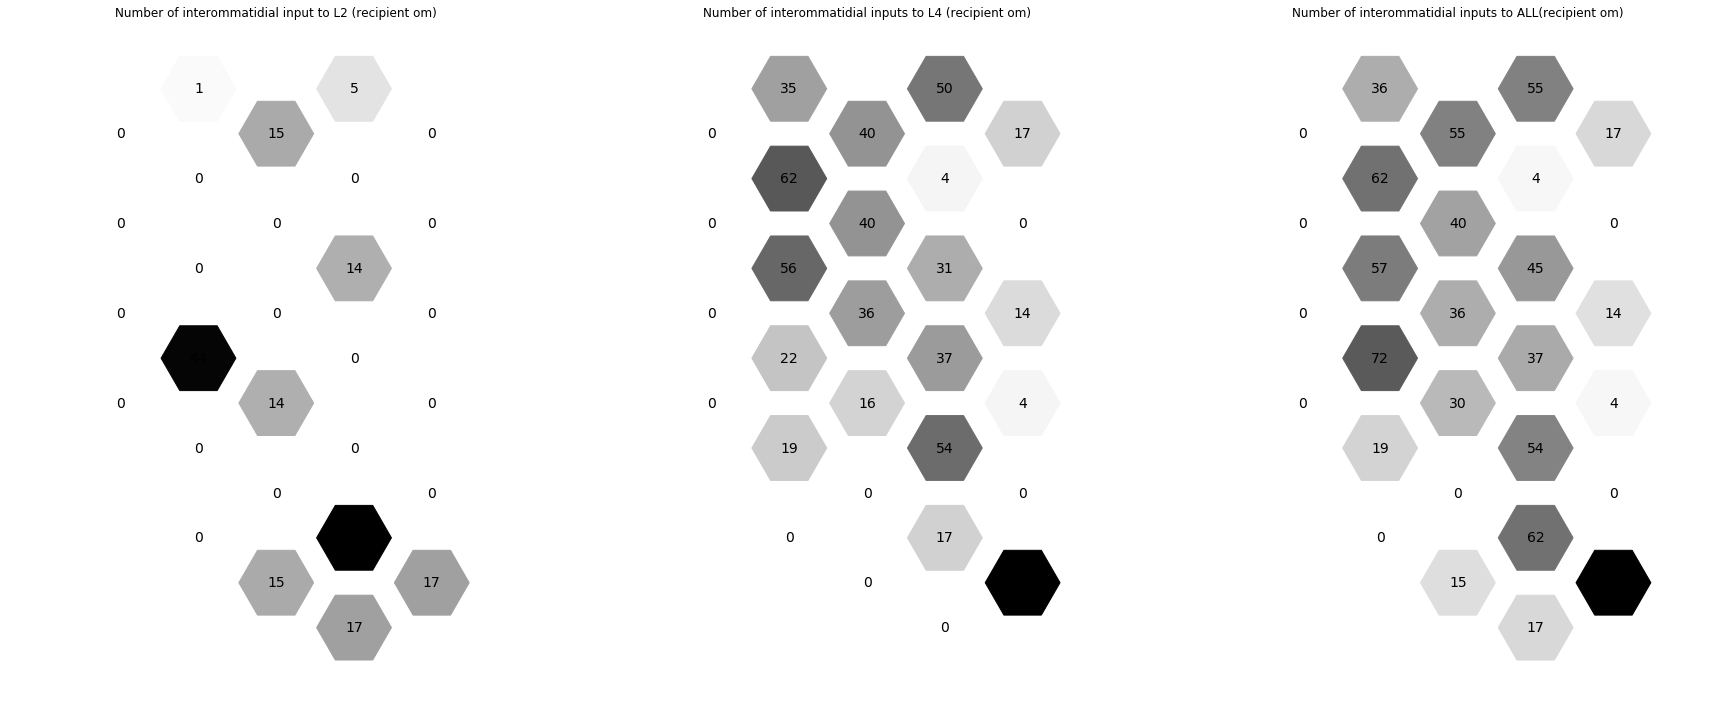

In [15]:
fig, ax = plt.subplots(1, 3, figsize=[30, 15])
cm = linear_cmap(n_vals=100, max_colour='k')

l2_dat = {om: {'colour': cm(v/max(to_l2.values())), 
               'label': int(v)} for om, v in to_l2.items()}
l4_dat = {om: {'colour': cm(v/max(to_l4.values())), 
               'label': int(v)} for om, v in to_l4.items()}
all_dat = {om: {'colour': cm(v/max(to_all.values())), 
               'label': int(v)} for om, v in to_all.items()}

hexplot(node_data=l2_dat, ax=ax[0])
ax[0].set_title('Number of interommatidial input to L2 (recipient om)')
hexplot(node_data=l4_dat, ax=ax[1])
ax[1].set_title('Number of interommatidial inputs to L4 (recipient om)')
hexplot(node_data=all_dat, ax=ax[2])
ax[2].set_title('Number of interommatidial inputs to ALL(recipient om)')

plt.show()

In [16]:
out_to_l2 = dict.fromkeys(om_list, 0)
out_to_l4 = dict.fromkeys(om_list, 0)
out_to_all = dict.fromkeys(om_list, 0)
out_weirdos = []

for i, c in collaterals.iterrows():
        om = c.pre_om
        out_to_all[om] += 1
        if c.post_type == 'LMC_2':
            out_to_l2[om] += 1
        elif c.post_type == 'LMC_4':
            out_to_l4[om] += 1
        else:
            out_weirdos.append(c)

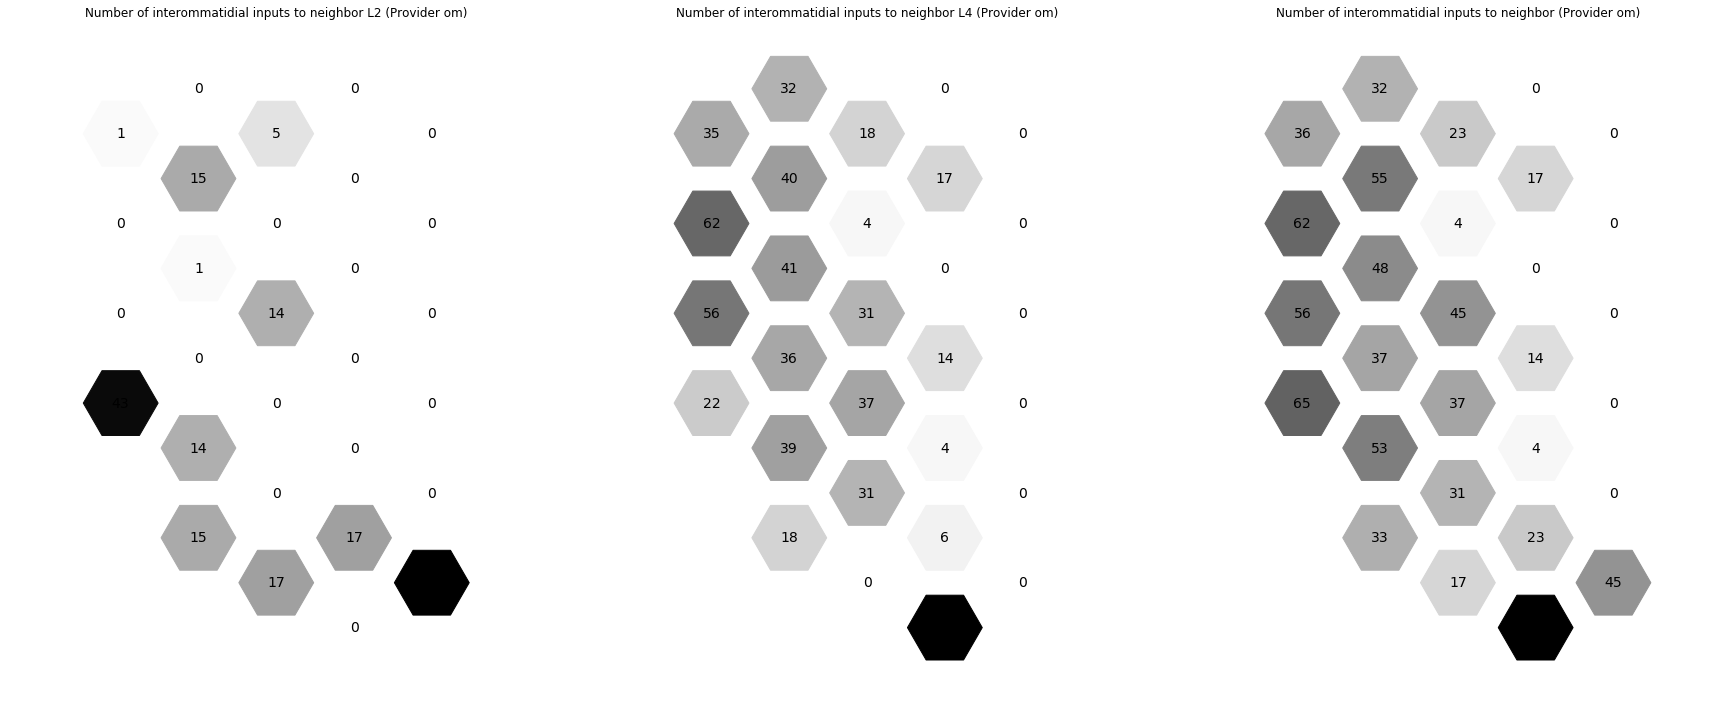

In [17]:
fig, ax = plt.subplots(1, 3, figsize=[30, 15])
cm = linear_cmap(n_vals=100, max_colour='k')

l2_dat = {om: {'colour': cm(v/max(out_to_l2.values())), 
               'label': int(v)} for om, v in out_to_l2.items()}
l4_dat = {om: {'colour': cm(v/max(out_to_l4.values())), 
               'label': int(v)} for om, v in out_to_l4.items()}
all_dat = {om: {'colour': cm(v/max(out_to_all.values())), 
                'label': int(v)} for om, v in out_to_all.items()}
hexplot(node_data=l2_dat, ax=ax[0])
ax[0].set_title('Number of interommatidial inputs to neighbor L2 (Provider om)')
hexplot(node_data=l4_dat, ax=ax[1])
ax[1].set_title('Number of interommatidial inputs to neighbor L4 (Provider om)')
hexplot(node_data=all_dat, ax=ax[2])
ax[2].set_title("Number of interommatidial inputs to neighbor (Provider om)")

plt.show()


In [18]:
to_l4_home = dict.fromkeys(om_list, 0)
to_l2_home = dict.fromkeys(om_list, 0)
to_all_home = dict.fromkeys(om_list, 0)

for i, h in homes.iterrows():
        om = h.post_om
        to_all_home[om] += 1
        if c.post_type == 'LMC_2':
            to_l2_home[om] += 1
        elif c.post_type == 'LMC_4':
            to_l4_home[om] += 1
        else:
            continue

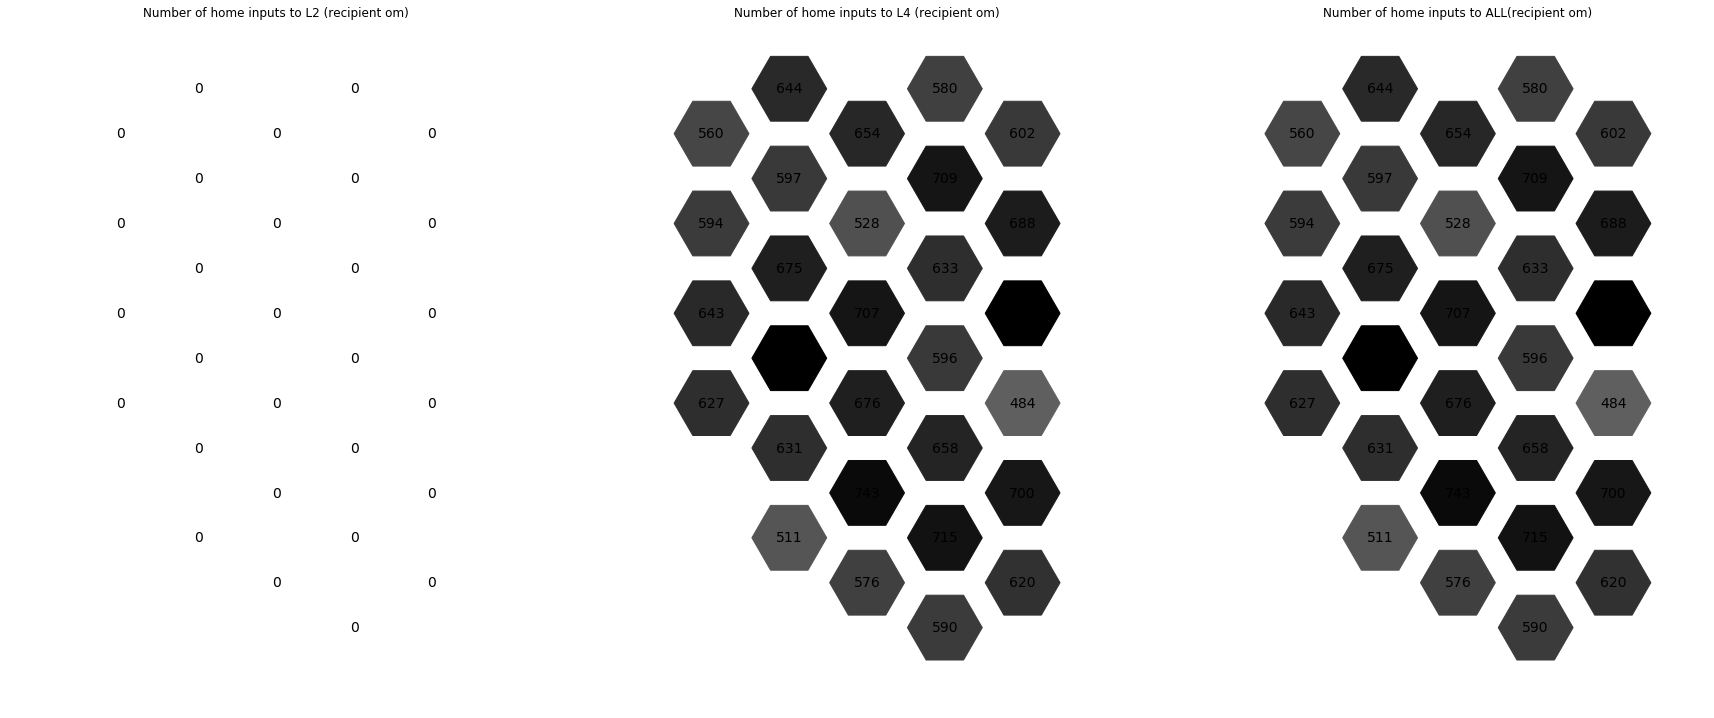

In [19]:
fig, ax = plt.subplots(1, 3, figsize=[30, 15])
cm = linear_cmap(n_vals=100, max_colour='k')

l2_dat = {om: {'colour': cm(v/(max(to_l2_home.values()) + 1)), 
               'label': int(v)} for om, v in to_l2_home.items()}
l4_dat = {om: {'colour': cm(v/(max(to_l4_home.values()) + 1)), 
               'label': int(v)} for om, v in to_l4_home.items()}
all_dat = {om: {'colour': cm(v/(max(to_all_home.values()) + 1)), 
               'label': int(v)} for om, v in to_all_home.items()}

hexplot(node_data=l2_dat, ax=ax[0])
ax[0].set_title('Number of home inputs to L2 (recipient om)')
hexplot(node_data=l4_dat, ax=ax[1])
ax[1].set_title('Number of home inputs to L4 (recipient om)')
hexplot(node_data=all_dat, ax=ax[2])
ax[2].set_title('Number of home inputs to ALL(recipient om)')

plt.show()
